Part III - Question 6 - Different Way of Generlising the Kernelised Perceptron

Overaraching aim of this project:

- To build a kernelised percetron algortihm for multi-class classification of handwritten digits


Notes:

#### The Perceptron
- The original perceptron is a linear classifier
- It can be thought of as just a single neuron (or node) of a neural network. So it takes in a row of data (the inputs) and outputs a single value. So it is also a binaruy classifier
- We want to change two things about it: binary into multi-class, and linear into non-linear descirion boundary though use of a kernel function.

#### Gaussian Kernel
- The kernel function computes the pairwise interactions/similariies between datapoints. The function is also known as the radial basis function and it introduces non-linearity and so allows us to creatre a non-linear descision boundry. It bassically just measures the distance between two points but in a weird way (the scaled negative squared Euclidean distance)
- In terms of why performance chnagegs with a change in $\gamma$, a larger $\gamma$ results in a rougher descision boundry which can lead to overfitting and a smaller $\gamma$ can lead to a smooother descision boundary, which can lead to underfitting.
- WHat is the **kernel trick**? This is the implicit mapping of the input features into a higher dimentional space - without actually calculating the new coordinates (so we never actually see the new features)
- Ok, so the kernel trick bassically allows us to skip a step. What do we want in the long run? We want to perform a simple dot product between some features and some weights to result in one scaler prediction. And if our data is non-linearly separable we would have had to apply certain feature maps to create lots more new features that might be linearly separable. However, it turns out (look up *Mercer's Theorem*) that certain functions (e.g the RBF) are equivilant to performing a dot product in a higher dimention (probably some Taylor expansion crap). This allows us to skip the feature creation step and go straight for the prediction (using the kernel).
- So it performs the dot-product in that high dim space without ever visiting it

#### Error Metric
- How are we going to measure the error?
- The test error in our code will be the proportion of misclassified samples.
- This is also known as the "0-1 loss" we then sum up these mistakes and divide by the number of total samples. So the end result is just an *error rate*

#### The One-vs-One Method
- How does this differ to our previous $\alpha$ matrix method (which btw was a One-vs-Rest method)?
- We now we are training lots of different binary classifiers to distinguish between each pair of digits rather than before we bassically trained 10 classifiers for digit 1-vs-rest, 2-vs-rest etc. 
- This method could potentially lead to better performance because each classifier can focus on finer details between digit-pairs but it would take longer to train. In fact the number of classifiers we would have to train increases quadratically with the number of classes. 

#### A quick note on our previous One-vs-Rest method
- So what we did before was lump 10 classifiers together insiode that one $\alpha$ matrix. So each row represented a classifier for a particular class. 
- Each row in $\alpha$ represented a 'One-vs-Rest' classifier for that class (the $j^{th}$ class/row)

#### Updating the Weights - learning
- This time $\alpha$ is a vector that
- The perceptron in general aims to find the maximum margin separating hyperplane (very similar to in SVMs)
- Mistake driven: So we only make changes to the model when it makes a mistake


#### The Prediction Process
- Each binary classifier gets to make one vote and then at the end we just chose the class that ended up with the most votes
- The actual predictions are calculate by a dot product between the kernel matrix and the alpha vector




In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from itertools import combinations
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
from joblib import Parallel, delayed
from sklearn.model_selection import KFold

In [3]:



def load_data(file_path):
    return np.loadtxt(file_path)


# Load the zipcombo.dat data
zipcombo_data = load_data("zipcombo.dat")

# What does it look like?
labels = zipcombo_data[:, 0]
images = zipcombo_data[:, 1:]

print(f"Rows: {zipcombo_data.shape[0]}\nColumns: {zipcombo_data.shape[1]}")


def get_fresh_random_data(zipcombo_data,random_state=42):
    train_data, test_data = train_test_split(zipcombo_data, test_size=0.2, random_state=random_state)
    train_labels = train_data[:, 0]
    train_images = train_data[:, 1:]
    test_labels = test_data[:, 0]
    test_images = test_data[:, 1:]
    return train_labels, train_images, test_labels, test_images


train_labels, train_images, test_labels, test_images = get_fresh_random_data(zipcombo_data)

Rows: 9298
Columns: 257


## Implementation of a One-vs-One Classifers for out Handwritten digits



So we need to define 2 classes to solve this problem, one binary classifier class and then another class to create, train etc one of these classifiers for each class pair.




In [12]:

def gaussian_kernel(X, Y, gamma):
    # To make things a bit faster, we'll use numpy's broadcasting and a lower precision
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)
    sq_dists = -2 * np.dot(X, Y.T) + np.sum(Y**2, axis=1) + np.sum(X**2, axis=1)[:, np.newaxis]
    return np.exp(-gamma * sq_dists)

class BinaryKernelPerceptron:
    # Lets make a binary classifier that can distinguish between two classes
    """
    Binary Kernel Perceptron
    We'll need to make a fitting function and a prediction function.
    The fitting function will take in our training data and train our model.
    The prediction function will take in our test data and return our predictions.

    alpha: The weights of our model
    train_data: The data we trained on
    kernel_matrix: The kernel matrix of our training data
    kernel_function: The kernel function we're using - Guassian for now
    kernel_param: The parameter for our kernel function - gamma for now
    """


    def __init__(self, kernel_function, kernel_param):
        self.kernel_function = kernel_function
        self.kernel_param = kernel_param
        self.alpha = None
        self.train_data = None

    def fit(self, X, y, tolerance=0.01, max_epochs=10):
        self.alpha = np.zeros(X.shape[0])
        self.train_data = X
        # It makes it a bit more efficient to precompute the kernel matrix
        self.kernel_matrix = self.kernel_function(X, X, self.kernel_param)

        for epoch in range(max_epochs):
            # Now for the core logic of the perceptron algorithm
            predictions = np.sign(np.dot(self.kernel_matrix, self.alpha))
            # We'll update our weights based on the errors we made
            errors = (y * predictions <= 0) # Where did we make errors?
            self.alpha[errors] += y[errors] # Go to those classes and update our weights
            # As a sort of early stopping
            if np.sum(errors) / X.shape[0] < tolerance:
                break

    def predict(self, X):
        # Now for the prediction function
        # We need to compute the kernel matrix between our test data and our training data
        kernel_values = self.kernel_function(X, self.train_data, self.kernel_param)
        # And then do the dot product between our weights and the kernel matrix
        return np.sign(np.dot(kernel_values, self.alpha))

class OneVsOneKernelPerceptron:
    """
    This class will take in a number of classes and train a binary classifier for each pair of classes.
    So for a large number of classes, it wont be quite as effient as our previous One-vs-Rest classifier.
    So how will we build it?
    - We'll need to train a binary classifier for each pair of classes
    - We'll need to predict using each classifier
    - Then find the class with the most votes
    - If we normalise those votes it would make kappa (a confidence vector)
    - Then to get a final prediction we could either take the class with the highest kappa value or sample from the distribution
    """
    def __init__(self, num_classes, kernel_function, kernel_param):
        self.num_classes = num_classes
        self.kernel_function = kernel_function
        self.kernel_param = kernel_param
        self.classifiers = {} # We will end up with k(k-1)/2 classifiers where k=10. So 45

    def fit(self, X, y, **fit_params):
        X = X.astype(np.float32) # might speed things up a bit
        # Ok, so lets train a binary classifier for each pair of classes
        for class1, class2 in combinations(range(self.num_classes), 2):
            idx = np.where((y == class1) | (y == class2))[0] # Where are the indices of the classes we want?
            X_pair, y_pair = X[idx], y[idx]
            y_pair = np.where(y_pair == class1, 1, -1) # We need to change the labels to be -1 or 1
            
            # Now we can train our binary classifier
            classifier = BinaryKernelPerceptron(self.kernel_function, self.kernel_param)
            classifier.fit(X_pair, y_pair, **fit_params)
            self.classifiers[(class1, class2)] = classifier

    def predict(self, X, return_confidences=False):
        X = X.astype(np.float32)
        # The votes will be a matrix of shape (num_samples, num_classes)
        # So each row will be the number of votes for each class, so to get the final prediction we could just take the argmax
        votes = np.zeros((X.shape[0], self.num_classes))
        confidences = np.zeros((X.shape[0], self.num_classes))

        for (class1, class2), classifier in self.classifiers.items():
            predictions = classifier.predict(X)
            # Ok, so to update the votes we need to add 1 to the class we predicted and -1 to the class we didn't predict
            votes[:, class1] += (predictions == 1)
            votes[:, class2] += (predictions == -1)
            confidences[:, class1] += (predictions == 1) * np.sum(classifier.alpha[classifier.alpha > 0])
            confidences[:, class2] += (predictions == -1) * np.sum(classifier.alpha[classifier.alpha > 0])

        if return_confidences:
            return np.argmax(votes, axis=1), confidences
        else:
            return np.argmax(votes, axis=1)



#### Some Useful Functions

In [15]:


def calculate_accuracy(actual, predicted):
    return np.mean(actual == predicted)


def softmax(x):
    # Subtracting the max can help with numerical stability
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)


def make_probabilistic_predictions(kappas):
    """
    How does this function work?
    - We'll take in our kappas (confidence vectors)
    - We'll convert them to probabilities using softmax
    - Then we can sample from the probabilities
    """
    predictions = []
    for kappa in kappas:
        # Convert kappa to probabilities using softmax
        kappa = np.expand_dims(kappa, axis=0)  # Ensure kappa is a 2D array
        probabilities = softmax(kappa)
        
        # Now we can sample from the probabilities
        predictions.append(np.random.choice(len(probabilities[0]), p=probabilities[0]))
    return np.array(predictions)




def plot_confusion_matrix(actual, predicted, num_classes):
    cm = confusion_matrix(actual, predicted, labels=np.arange(num_classes))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


## Lets test out our One-vs-One clasifier

(Max Confidence) Kernelised Perceptron Accuracy: 96.99%
(Sampled from Kappa) Kernelised Perceptron Accuracy: 73.98%
We dont need this confusion matrix, just curious


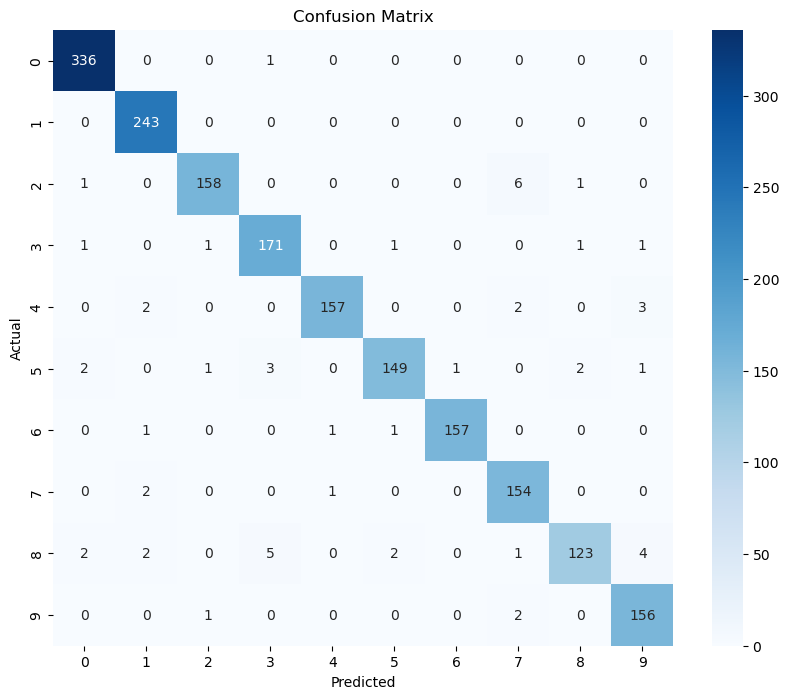

In [16]:



num_classes = 10
gamma = 0.47
classifier = OneVsOneKernelPerceptron(num_classes, gaussian_kernel, gamma)
classifier.fit(train_images, train_labels, max_epochs=100, tolerance=0.001)


predictions,kappas = classifier.predict(test_images, True)
probabilistic_predictions = make_probabilistic_predictions(kappas)



accuracy = calculate_accuracy(test_labels, predictions)
print(f"(Max Confidence) Kernelised Perceptron Accuracy: {accuracy:.2%}")
prob_accuracy = calculate_accuracy(test_labels, probabilistic_predictions)
print(f"(Sampled from Kappa) Kernelised Perceptron Accuracy: {prob_accuracy:.2%}")


# Plot confusion matrix for shuffled perceptron
print("We dont need this confusion matrix, just curious")
plot_confusion_matrix(test_labels, predictions, num_classes=num_classes)


Note: So taking the max confidence seems to work much better. So they probably dont really represent probabilites perfectly. I.e kappa is ont properly calibrated. 

In [93]:
# Convert data to float32 for faster computations
zipcombo_data = zipcombo_data.astype(np.float32)
# I did some tests before and found that these values are a good range to search over
gamma_values = np.array([0.1,0.5, 1, 2, 3], dtype=np.float32)


results = {}


for gamma in gamma_values:
    # We would to store the train and test errors for each run (20 runs in total)
    train_errors = []
    test_errors = []

    
    for run in range(20):
        print(f"Gamma value: {gamma}, run: {run}")
        # Get a fresh random split of the data
        train_labels, train_images, test_labels, test_images = get_fresh_random_data(zipcombo_data,random_state=run)

        # Create an instance of OneVsOneKernelPerceptron with the gaussian_kernel and the current gamma
        classifier = OneVsOneKernelPerceptron(num_classes=10, kernel_function=gaussian_kernel, kernel_param=gamma)
        classifier.fit(train_images, train_labels)

        # Predict on the training data and calculate the training error rate
        train_predictions = classifier.predict(train_images)
        train_error_rate = np.mean(train_predictions != train_labels)
        train_errors.append(train_error_rate)

        # Predict on the testing data and calculate the test error rate
        test_predictions = classifier.predict(test_images)
        test_error_rate = np.mean(test_predictions != test_labels)
        test_errors.append(test_error_rate)

    # El Results
    train_error_mean = np.mean(train_errors)
    train_error_std = np.std(train_errors)
    test_error_mean = np.mean(test_errors)
    test_error_std = np.std(test_errors)

    results[gamma] = {
        'train_error_mean': train_error_mean,
        'train_error_std': train_error_std,
        'test_error_mean': test_error_mean,
        'test_error_std': test_error_std,
    }


Gamma value: 0.10000000149011612, run: 0
Gamma value: 0.10000000149011612, run: 1
Gamma value: 0.10000000149011612, run: 2
Gamma value: 0.10000000149011612, run: 3
Gamma value: 0.10000000149011612, run: 4
Gamma value: 0.10000000149011612, run: 5
Gamma value: 0.10000000149011612, run: 6
Gamma value: 0.10000000149011612, run: 7
Gamma value: 0.10000000149011612, run: 8
Gamma value: 0.10000000149011612, run: 9
Gamma value: 0.10000000149011612, run: 10
Gamma value: 0.10000000149011612, run: 11
Gamma value: 0.10000000149011612, run: 12
Gamma value: 0.10000000149011612, run: 13
Gamma value: 0.10000000149011612, run: 14
Gamma value: 0.10000000149011612, run: 15
Gamma value: 0.10000000149011612, run: 16
Gamma value: 0.10000000149011612, run: 17
Gamma value: 0.10000000149011612, run: 18
Gamma value: 0.10000000149011612, run: 19
Gamma value: 0.5, run: 0
Gamma value: 0.5, run: 1
Gamma value: 0.5, run: 2
Gamma value: 0.5, run: 3
Gamma value: 0.5, run: 4
Gamma value: 0.5, run: 5
Gamma value: 0.5, ru

In [96]:
# Lets put these results into a tidy dataframe

df_basic_results = pd.DataFrame()
df_basic_results['gamma'] = gamma_values
df_basic_results['train_error_mean'] = [result['train_error_mean'] for result in results.values()]
df_basic_results['train_error_std'] = [result['train_error_std'] for result in results.values()]
df_basic_results['test_error_mean'] = [result['test_error_mean'] for result in results.values()]
df_basic_results['test_error_std'] = [result['test_error_std'] for result in results.values()]
df_basic_results.to_csv('basic_results.csv', index=False)
df_basic_results

,gamma,train_error_mean,train_error_std,test_error_mean,test_error_std
0,0.1,0.001271,0.000167,0.045538,0.004758
1,0.5,0.000121,0.000040,0.032124,0.004324
2,1.0,0.000000,0.000000,0.050215,0.005481
3,2.0,0.000000,0.000000,0.293306,0.009018
4,3.0,0.000000,0.000000,0.460538,0.008688


Best gamma value: 0.4932323232323233


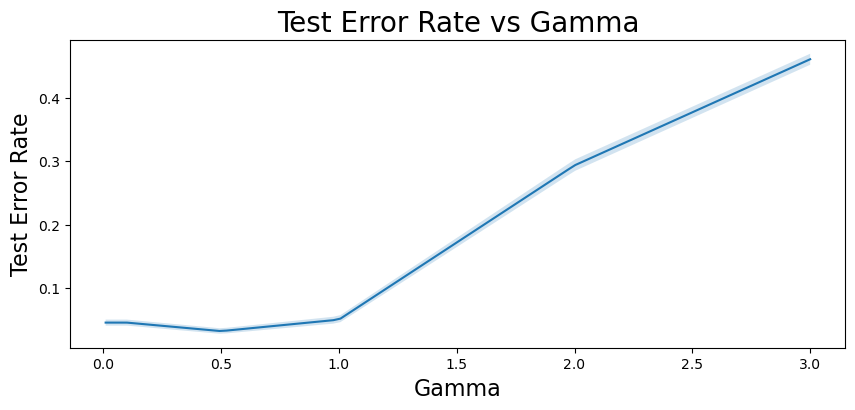

In [98]:
# Lets interpolate to find the best gamma value (which would be the gamma that resulted in the lowest test error rate)

# Create a new dataframe with interpolated values
df_basic_results_interpolated = pd.DataFrame()
df_basic_results_interpolated['gamma'] = np.linspace(0.01, 3.0, 100)
df_basic_results_interpolated['test_error_mean'] = np.interp(df_basic_results_interpolated['gamma'], df_basic_results['gamma'], df_basic_results['test_error_mean'])
df_basic_results_interpolated['test_error_std'] = np.interp(df_basic_results_interpolated['gamma'], df_basic_results['gamma'], df_basic_results['test_error_std'])

# Find the gamma value with the lowest test error rate
best_gamma = df_basic_results_interpolated['gamma'][df_basic_results_interpolated['test_error_mean'].idxmin()]
print(f"Best gamma value: {best_gamma}")

# We could plot it as well
plt.figure(figsize=(10, 4),dpi=100)
plt.plot(df_basic_results_interpolated['gamma'], df_basic_results_interpolated['test_error_mean'])
plt.fill_between(df_basic_results_interpolated['gamma'], df_basic_results_interpolated['test_error_mean'] - df_basic_results_interpolated['test_error_std'], df_basic_results_interpolated['test_error_mean'] + df_basic_results_interpolated['test_error_std'], alpha=0.2)
plt.xlabel('Gamma', fontsize=16)
plt.ylabel('Test Error Rate', fontsize=16)
plt.title('Test Error Rate vs Gamma', fontsize=20)
plt.show()

# Now Onto Part 2 - Cross Valadation

In [7]:


def cross_validate_gamma(train_data, gamma, num_classes, kernel_function):
    kf = KFold(n_splits=5)
    validation_errors = []

    for train_index, val_index in kf.split(train_data):
        train_fold, val_fold = train_data[train_index], train_data[val_index]
        classifier = OneVsOneKernelPerceptron(num_classes=num_classes, kernel_function=kernel_function, kernel_param=gamma)
        classifier.fit(train_fold[:, 1:], train_fold[:, 0])
        
        val_predictions = classifier.predict(val_fold[:, 1:])
        validation_error = np.mean(val_predictions != val_fold[:, 0])
        validation_errors.append(validation_error)

    return np.mean(validation_errors)


In [9]:
import numpy as np

# Define the gamma values and the number of runs
gamma_values = [0.05,0.25,0.4,0.6,0.8,1.2]
num_runs = 20

# Initialize the lists to store the best gamma values and test errors for each run
best_gammas = []
test_errors = []



# Adjusted main loop
mean_validation_errors = []

for run in tqdm(range(num_runs)):
    train_data, test_data = train_test_split(zipcombo_data, test_size=0.2, random_state=run)

    # Parallel processing for different gamma values
    validation_errors_for_gammas = Parallel(n_jobs=-1)(delayed(cross_validate_gamma)(train_data, gamma, 10, gaussian_kernel) for gamma in gamma_values)
    best_gamma = gamma_values[np.argmin(validation_errors_for_gammas)]
    best_gammas.append(best_gamma)

    classifier = OneVsOneKernelPerceptron(num_classes=10, kernel_function=gaussian_kernel, kernel_param=best_gamma)
    classifier.fit(train_data[:, 1:], train_data[:, 0])

    test_predictions = classifier.predict(test_data[:, 1:])
    test_error = np.mean(test_predictions != test_data[:, 0])
    test_errors.append(test_error)

    

# Calculate the mean and standard deviation of the best gamma values and test errors
mean_best_gamma = np.mean(best_gammas)
std_best_gamma = np.std(best_gammas)
mean_test_error = np.mean(test_errors)
std_test_error = np.std(test_errors)

# Print the results
print(f"Mean best gamma: {mean_best_gamma} ± {std_best_gamma}")
print(f"Mean test error: {mean_test_error} ± {std_test_error}")

100%|██████████| 20/20 [03:59<00:00, 12.00s/it]

Mean best gamma: 0.475 ± 0.12093386622447821
Mean test error: 0.032204301075268824 ± 0.004263613740410073


$\underline{\text{Cross-Validation Results}}$



Mean best gamma: $0.48 ± 0.12$

Mean test error: $0.032 ± 0.004$